## Training a sentiment classification CNN model using Keras

In [1]:
import os

#############################################
## Change this working directory to your own working directory
working_dir = r"D:\Sentiment140_Classification"
#############################################

## Set training and test files
training_tweet_filename = os.path.join(working_dir, 'training_text.csv')
training_label_filename = os.path.join(working_dir, 'training_label.csv')
test_tweet_filename = os.path.join(working_dir, 'testing_text.csv')
test_label_filename = os.path.join(working_dir, 'testing_label.csv')

## Set word2vec file, parameter file for model, and model pipeline file
w2v_embeddings_filename = os.path.join(working_dir, 'w2vec.txt')
#params_file_path = os.path.join(working_dir, "keras_params.tsv")
model_file = os.path.join(working_dir, 'keras_model') 

### Import packages & show version of TATK package used

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import matplotlib.pyplot as plt
import pandas as pd
import re
from scipy import stats
from sklearn.model_selection import train_test_split
import num2words
from nltk.tokenize import TweetTokenizer
import seaborn as sns

from tatk.pipelines.text_classification.keras_text_classifier import KerasTextClassifier
!pip show azureml-tatk

C:\Users\remoteuser\AppData\local\AmlWorkbench\Python\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Name: azureml-tatk
Version: 0.0.687318
Summary: Microsoft Azure Machine Learning Text Analytics Toolkit
Home-page: https://msdata.visualstudio.com/DefaultCollection/AlgorithmsAndDataScience/_git/TATK
Author: Microsoft Corporation
Author-email: azml-tatk@microsoft.com
License: UNKNOWN
Location: c:\users\remoteuser\appdata\local\amlworkbench\python\lib\site-packages
Requires: keras, pytest, azure-ml-api-sdk, unidecode, lxml, tensorflow-gpu, nltk, matplotlib, sklearn-crfsuite, ipython, pdfminer.six, h5py, requests, docker, bqplot, scikit-learn, azure-storage, pandas, nose, validators, pyspark, scipy, gensim, numpy


#### Define functions for reading in and pre-processing tweets

In [11]:
# Data processing
# In the following code, we replace Emails, URLS, emoticons etc with special labels
pos_emoticons=["(^.^)","(^-^)","(^_^)","(^_~)","(^3^)","(^o^)","(~_^)","*)",":)",":*",":-*",":]",":^)",":}",
               ":>",":3",":b",":-b",":c)",":D",":-D",":O",":-O",":o)",":p",":-p",":P",":-P",":Þ",":-Þ",":X",
               ":-X",";)",";-)",";]",";D","^)","^.~","_)m"," ~.^","<=8","<3","<333","=)","=///=","=]","=^_^=",
               "=<_<=","=>.<="," =>.>="," =3","=D","=p","0-0","0w0","8D","8O","B)","C:","d'-'","d(>w<)b",":-)",
               "d^_^b","qB-)","X3","xD","XD","XP","ʘ‿ʘ","❤","💜","💚","💕","💙","💛","💓","💝","💖","💞",
               "💘","💗","😗","😘","😙","😚","😻","😀","😁","😃","☺","😄","😆","😇","😉","😊","😋","😍",
               "😎","😏","😛","😜","😝","😮","😸","😹","😺","😻","😼","👍"]

neg_emoticons=["--!--","(,_,)","(-.-)","(._.)","(;.;)9","(>.<)","(>_<)","(>_>)","(¬_¬)","(X_X)",":&",":(",":'(",
               ":-(",":-/",":-@[1]",":[",":\\",":{",":<",":-9",":c",":S",";(",";*(",";_;","^>_>^","^o)","_|_",
               "`_´","</3","<=3","=/","=\\",">:(",">:-(","💔","☹️","😌","😒","😓","😔","😕","😖","😞","😟",
               "😠","😡","😢","😣","😤","😥","😦","😧","😨","😩","😪","😫","😬","😭","😯","😰","😱","😲",
               "😳","😴","😷","😾","😿","🙀","💀","👎"]

# Emails
emailsRegex=re.compile(r'[\w\.-]+@[\w\.-]+')

# Mentions
userMentionsRegex=re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)')

#Urls
urlsRegex=re.compile('r(f|ht)(tp)(s?)(://)(.*)[.|/][^ ]+') # It may not be handling all the cases like t.co without http

#Numerics
numsRegex=re.compile(r"\b\d+\b")

punctuationNotEmoticonsRegex=re.compile(r'(?<=\w)[^\s\w](?![^\s\w])')

emoticonsDict = {}
for i,each in enumerate(pos_emoticons):
    emoticonsDict[each]=' POS_EMOTICON_'+num2words.num2words(i).upper()+' '
    
for i,each in enumerate(neg_emoticons):
    emoticonsDict[each]=' NEG_EMOTICON_'+num2words.num2words(i).upper()+' '
    
# use these three lines to do the replacement
rep = dict((re.escape(k), v) for k, v in emoticonsDict.items())
emoticonsPattern = re.compile("|".join(rep.keys()))


##########################
def read_tweets(filename):
    """Read the raw tweet data from a file. Replace Emails etc with special tokens """
    with open(filename, 'r') as f:
        all_lines=f.readlines()
        padded_lines=[]
        for line in all_lines:
            line = emoticonsPattern.sub(lambda m: rep[re.escape(m.group(0))], line.lower().strip())
            line = userMentionsRegex.sub(' USER ', line )
            line = emailsRegex.sub(' EMAIL ', line )
            line=urlsRegex.sub(' URL ', line)
            line=numsRegex.sub(' NUM ',line)
            line=punctuationNotEmoticonsRegex.sub(' PUN ',line)
            line=re.sub(r'(.)\1{2,}', r'\1\1',line)
            words_tokens=[token for token in TweetTokenizer().tokenize(line)]                    
            line= ' '.join(token for token in words_tokens )         
            padded_lines.append(line)
    return padded_lines

### Read in training tweets and create a dataframe with tweets and their sentment labels

In [18]:
## Read in tweet file. Labels are 4 and 0 (4 being positive and 0 being negative)
tweets = read_tweets(training_tweet_filename)

with open(training_label_filename, 'r') as f:
    all_lines=f.readlines()
    tweet_labels = []
    for line in all_lines:
        line = line.strip()
        label = 0
        if line == '4':
            label = 1#'positive'
        #else:
        #    label = 'negative'
        tweet_labels.append(label)

df_train = pd.DataFrame({'tweets':tweets, 'labels':tweet_labels}, columns=['tweets','labels'])
display(df_train[:3])

,tweets,labels
0,damn fixtated on USER lovely thighs PUN hips o...,1
1,god bless firefox PUN s ' restore previous ses...,1
2,USER http://twitpic PUN com PUN 6vn4a - dang g...,1


### Define Keras classifier 

In [3]:
keras_text_classifier = KerasTextClassifier(embedding_file_path=w2v_embeddings_filename, 
                                            input_col="tweets", label_col="labels",
                                            model_type = 'binary', binary_format = True)

KerasTextClassifier::create_pipeline ==> start
Word2VecVectorizer::load_embeddings ==> start


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xaf in position 0: invalid start byte

### Fit Keras classifier 

In [41]:
keras_text_classifier.get_params()

{'binary_format': False,
 'callbacks': False,
 'embedding_file_path': 'D:\\Sentiment140_Classification\\w2vec.txt',
 'input_col': 'tweets',
 'label_col': 'labels',
 'limit': None,
 'model_type': 'binary',
 'num_classes': 1,
 'prediction_col': 'prediction',
 'probabilities_col': 'probabilities'}

In [22]:
keras_text_classifier.fit(df_train)

KerasTextClassifier::fit ==> start
GenerateIndexTransformer::tatk_fit_transform ==> startNltkPreprocessor::tatk_fit_transform ==> start

GenerateIndexTransformer::tatk_fit_transform ==> end 	 Time taken: 0.0 mins
NltkPreprocessor::tatk_fit_transform ==> end 	 Time taken: 0.31 mins
Word2VecVectorizer::tatk_fit_transform ==> start
Word2VecVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.34 mins
KerasTextClassifierLearner::tatk_fit ==> start
(1280000, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          2475950   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         37750     
_________________________________________________________________
global_max

KerasTextClassifier(binary_format=False, callbacks=False,
          embedding_file_path='D:\\Sentiment140_Classification\\w2vec.txt',
          input_col='tweets', label_col='labels', limit=None,
          model_type='binary', num_classes=1, prediction_col='prediction',
          probabilities_col='probabilities')

### Save model file

In [40]:
keras_text_classifier.save(model_file)

BaseTextModel::save ==> start
TatkPipeline::save ==> start
copy embedding file from  D:\Sentiment140_Classification\w2vec.txt
Time taken: 0.0 mins
TatkPipeline::save ==> end
Time taken: 0.0 mins
BaseTextModel::save ==> end


### Load model and evaluate performance on a set of training data

In [49]:
keras_text_classifier_reloaded = KerasTextClassifier.load(model_file)

BaseTextModel::load ==> start
TatkPipeline::load ==> start
Word2VecVectorizer: Word2Vec model loaded from D:\Sentiment140_Classification\keras_model\pipeline\vectorizer\embedding_table.txt
Time taken: 0.08 mins
TatkPipeline::load ==> end
Time taken: 0.08 mins
BaseTextModel::load ==> end


In [50]:
predictions = keras_text_classifier_reloaded.evaluate(df_train.head(5000))

KerasTextClassifier::evaluate ==> start
GenerateIndexTransformer::tatk_transform ==> startNltkPreprocessor::tatk_transform ==> start

GenerateIndexTransformer::tatk_transform ==> end 	 Time taken: 0.0 mins
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.0 mins
Word2VecVectorizer::tatk_transform ==> start
Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.01 mins
KerasTextClassifierLearner::tatk_predict ==> start
KerasTextClassifierLearner::tatk_predict ==> end 	 Time taken: 0.01 mins
[[1868  607]
 [ 373 2152]]
macro_f1=0.803365610266466
Time taken: 0.02 mins
KerasTextClassifier::evaluate ==> end


C:\Users\remoteuser\AppData\local\AmlWorkbench\Python\lib\site-packages\tatk\core\tatk_multi_col_estimator.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataset[col_name] = [row for row in res]


### Plot confusion matrix

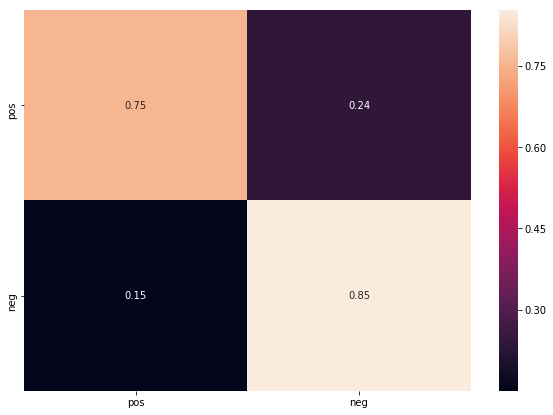

In [51]:
conf_matrix = pd.DataFrame(predictions[0], index = ['pos', 'neg'], columns = ['pos', 'neg'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_matrix / conf_matrix.sum(axis=1), annot=True)